# Text-to-Image Generation with Stable Diffusion and OpenVINO™

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!


This notebook demonstrates how to convert and run stable diffusion model using OpenVINO.

Notebook contains the following steps:
1. Convert PyTorch models to ONNX format.
2. Convert ONNX models to OpenVINO IR format using Model Optimizer tool.
3. Run Stable Diffusion pipeline with OpenVINO.

## Prerequisites

>**Note**:
>The original model (e.g. `stable-diffusion-v1-4`) requires you to accept the model license before downloading or using its weights, visit the [stable-diffusion-v1-4 card](https://huggingface.co/CompVis/stable-diffusion-v1-4) to read accept the license before you proceed.
>To use this diffusion model, you must be a registered user in 🤗 Hugging Face Hub. You will need to use an access token for the code below to run. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on HuggingFace Hub in notebook environment using following code:
```python
## login to huggingfacehub to get access to pretrained model 
from huggingface_hub import notebook_login, whoami

try:
    whoami()
    print('Authorization token already provided')
except OSError:
    notebook_login()
```

In this tutorial we will use a Stable Diffusion model fine-tuned using images from Midjourney v4 (another popular solution for text to image generation), 
you can find more details about this model on the [model card](https://huggingface.co/prompthero/openjourney). The same steps for conversion and running the pipeline are applicable to other solutions based on Stable Diffusion.


In [1]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


## Create Pytorch Models pipeline
StableDiffusionPipeline is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model.

In [2]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney", force_download=True)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

## Convert models to OpenVINO Intermediate representation (IR) format

OpenVINO supports PyTorch\* through export to the ONNX\* format. We will use `torch.onnx.export` function for obtaining ONNX model, 
you can learn more in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We need to provide a model object, input data for model tracing and a path for saving the model.Optionally, we can provide target onnx opset for conversion and other parameters specified in documentation (e.g. input and output names or dynamic shapes).

While ONNX models are directly supported by OpenVINO™ runtime, it can be useful to convert them to IR format to take advantage of advanced OpenVINO optimization tools and features. We will use OpenVINO Model Optimizer tool for conversion model to IR format and compression weights to FP16 format. 

The model consists from three important parts:
* Text Encoder for creation condition to generate image from text prompt
* Unet for step by step denoising latent image representation
* Autoencoder (VAE) for encdoing input image to latent space (if required) and decoding latent space to image back after generation

Let's convert each part

### Text Encoder

The text-encoder is responsible for transforming the input prompt, e.g. "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of text encoder is tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are 2 tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in model and `pooler_out` - Pooled output for whole model hidden states. We will use `opset_version=14`, because model contains `triu` operation, supported in ONNX only starting from this opset.

In [3]:
from pathlib import Path
import torch
from openvino.tools import mo
from openvino.runtime import serialize, Core

TEXT_ENCODER_ONNX_PATH = Path('text_encoder.onnx')
TEXT_ENCODER_OV_PATH = TEXT_ENCODER_ONNX_PATH.with_suffix('.xml')

core = Core()

def convert_encoder_onnx(pipe: StableDiffusionPipeline, onnx_path:Path):
    """
    Convert Text Encoder model to ONNX. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionPipeline): Stable Diffusion pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        text = 'a photo of an astronaut riding a horse on mars'
        text_encoder = pipe.text_encoder
        input_ids = pipe.tokenizer(
            text,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids

        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            # infer model, just to make sure that it works
            text_encoder(input_ids)
            # export model to ONNX format
            torch.onnx.export(
                text_encoder,  # model instance
                input_ids,  # inputs for model tracing
                onnx_path,  # output file for saving result
                input_names=['input_ids'],  # model input name for onnx representation
                output_names=['last_hidden_state', 'pooler_out'],  # model output names for onnx representation
                opset_version=14  # onnx opset version for export
            )
        print('Text Encoder successfully converted to ONNX')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder_onnx(pipe, TEXT_ENCODER_ONNX_PATH)
    text_encoder = mo.convert_model(
        TEXT_ENCODER_ONNX_PATH, compress_to_fp16=True)
    serialize(text_encoder, str(TEXT_ENCODER_OV_PATH))
    print('Text Encoder successfully converted to IR')
else:
    text_encoder = core.read_model(TEXT_ENCODER_OV_PATH)
    print(f"Text encoder successfully loaded from {TEXT_ENCODER_OV_PATH}")

Text encoder successfully loaded from text_encoder.xml


### U-net

Unet model has 3 inputs:
* `sample` - latent image sample from previous step, generation process has not been started yet, so we will use random noise
* `timestep` - current scheduler step
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

In [4]:
import numpy as np

UNET_ONNX_PATH = Path('unet/unet.onnx')
UNET_OV_PATH = UNET_ONNX_PATH.parents[1] / 'unet.xml'


def convert_unet_onnx(pipe:StableDiffusionPipeline, onnx_path:Path):
    """
    Convert Unet model to ONNX, then IR format. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionPipeline): Stable Diffusion pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        # prepare inputs
        text = 'a photo of an astronaut riding a horse on mars'
        text_encoder = pipe.text_encoder
        input_ids = pipe.tokenizer(
            text,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids
        with torch.no_grad():
            text_encoder_output = text_encoder(input_ids)
        latents_shape = (2, 4, 512 // 8, 512 // 8)
        latents = torch.randn(latents_shape)
        t = torch.from_numpy(np.array(1, dtype=float))

        # model size > 2Gb, it will be represented as onnx with external data files, we will store it in separated directory for avoid a lot of files in current directory
        onnx_path.parent.mkdir(exist_ok=True, parents=True)

        max_length = input_ids.shape[-1]

        # we plan to use unet with classificator free guidence, in this cace conditionaly generated text embeddings should be concatenated with uncoditional
        uncond_input = pipe.tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids)[0]
        encoder_hidden_state = torch.cat([uncond_embeddings, text_encoder_output[0]])

        # to make sure that model works
        pipe.unet(latents, t, encoder_hidden_state)[0]

        with torch.no_grad():
            torch.onnx.export(
                pipe.unet, 
                (latents, t, encoder_hidden_state), str(onnx_path),
                input_names=['sample', 'timestep', 'encoder_hidden_state'],
                output_names=['out_sample']
            )
        print('Unet successfully converted to ONNX')


if not UNET_OV_PATH.exists():
    convert_unet_onnx(pipe, UNET_ONNX_PATH)
    unet = mo.convert_model(UNET_ONNX_PATH, compress_to_fp16=True)
    print('Unet successfully converted to IR')
else:
    unet = core.read_model(UNET_OV_PATH)
    print(f"Unet successfully loaded from {UNET_OV_PATH}")

Unet successfully loaded from unet.xml


### VAE

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. VAE enxoder is also responsible for encoding intial input image in image-to-image processing tasks, but for text-to-image task we **only need the VAE decoder**.

In our inference pipeline, we will need only decoding part of VAE, but forward function, which used for tracing runs encoding too. For obtaining only necessary part of model, we will wrap it into new model class.

In [5]:
VAE_ENCODER_ONNX_PATH = Path('vae_encoder.onnx')
VAE_ENCODER_OV_PATH = VAE_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_encoder_onnx(pipe: StableDiffusionPipeline, onnx_path: Path):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(image).latent_dist.sample()

    if not onnx_path.exists():
        vae_encoder = VAEEncoderWrapper(pipe.vae)
        vae_encoder.eval()
        image = torch.zeros((1, 3, 512, 512))
        with torch.no_grad():
            torch.onnx.export(vae_encoder, image, onnx_path, input_names=[
                              'image'], output_names=['image_latent'])
        print('VAE encoder successfully converted to ONNX')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder_onnx(pipe, VAE_ENCODER_ONNX_PATH)
    vae_encoder = mo.convert_model(VAE_ENCODER_ONNX_PATH, compress_to_fp16=True)
    serialize(vae_encoder, str(VAE_ENCODER_OV_PATH))
    print('VAE encoder successfully converted to IR')
else:
    vae_encoder = core.read_model(VAE_ENCODER_OV_PATH)
    print(f"VAE encoder successfully loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_ONNX_PATH = Path('vae_decoder.onnx')
VAE_DECODER_OV_PATH = VAE_DECODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_decoder_onnx(pipe: StableDiffusionPipeline, onnx_path: Path):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    if not onnx_path.exists():
        vae_decoder = VAEDecoderWrapper(pipe.vae)
        latents = torch.zeros((1, 4, 64, 64))

        vae_decoder.eval()
        with torch.no_grad():
            torch.onnx.export(vae_decoder, latents, onnx_path, input_names=[
                              'latents'], output_names=['sample'])
        print('VAE decoder successfully converted to ONNX')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder_onnx(pipe, VAE_DECODER_ONNX_PATH)
    vae_decoder = mo.convert_model(VAE_DECODER_ONNX_PATH, compress_to_fp16=True)
    print('VAE decoder successfully converted to IR')
else:
    vae_decoder = core.read_model(VAE_DECODER_OV_PATH)
    print(f"VAE decoder successfully loaded from {VAE_DECODER_OV_PATH}")

VAE encoder successfully loaded from vae_encoder.xml
VAE decoder successfully loaded from vae_decoder.xml


In [6]:
# to reduce memory consumption, remove pipeline form memory as we will not use it anymore
del pipe


## Prepare Inference Pipeline

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.

<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(we will use it in our pipeline)

Theory on how the scheduler algorithm function works is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

In [7]:
import inspect
from typing import List, Optional, Union

import PIL
import cv2

from transformers import CLIPTokenizer
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (Model):
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = self.unet.input(0).shape[2] * 8
        self.width = self.unet.input(0).shape[3] * 8
        self.tokenizer = tokenizer

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        gif: Optional[bool] = False,
        **kwargs,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            latents (torch.FloatTensor, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random generator.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
            gif (bool, *optional*, False):
                Flag for storing all steps results or not.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.array
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        if seed is not None:
            np.random.seed(seed)

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        img_buffer = []
        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_embeddings = self.text_encoder(text_input.input_ids)[self._text_encoder_output]
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(image)

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps = self.scheduler.timesteps

        # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents * self.scheduler.sigmas[0].numpy()

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
            if gif:
                image = self.vae_decoder(1 / 0.18215 * latents)[self._vae_d_output]
                image = self.postprocess_image(image, meta, output_type)
                img_buffer.extend(image)

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image, 'iterations': img_buffer}

    def prepare_latents(self, image=None):
        if image is None:
            latents_shape = (1, 4, self.height // 8, self.width // 8)
            latents = np.random.randn(
                *latents_shape
            )
            return latents, {}
        input_image, meta = preprocess(image)
        latents = self.vae_encoder(input_image)[self._vae_e_output]
        return latents, meta

    def postprocess_image(self, image, meta, output_type="pil"):
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image
        

## Configure Inference Pipeline

First, we should create instances of OpenVINO Model.

In [8]:
from openvino.runtime import Core
core = Core()
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, 'CPU')

In [9]:
unet_model = core.compile_model(UNET_OV_PATH, 'CPU')

In [10]:
vae = core.compile_model(VAE_DECODER_OV_PATH, 'CPU')

Model tokenizer and scheduler are also important parts of the pipeline. Let's define them and put all components together

In [11]:
from transformers import CLIPTokenizer
from diffusers.schedulers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_decoder=vae,
    scheduler=lms
)

Now, we are ready to define a text prompt for image generation and run inference pipeline.
Optionally, you can also change the random generator seed for latent state initialization and number of steps.
> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.


In [12]:
import ipywidgets as widgets

text_prompt = widgets.Text(value='Corgi in Salvador Dali style', description='your text')
num_steps = widgets.IntSlider(min=1, max=50, value=10, description='steps:')
seed = widgets.IntSlider(min=0, max=1024, description='seed: ', value=42)
widgets.VBox([text_prompt, seed, num_steps])

In [13]:
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')

Pipeline settings
Input text: Corgi in Salvador Dali style
Seed: 42
Number of steps: 10


In [14]:
result = ov_pipe(text_prompt.value, num_inference_steps=num_steps.value, seed=seed.value, gif=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Finally, let's save generation results.
Our pipeline returns several results: `sample` contains final generated image, `iterations` contains list of intermediate results for each step.

In [15]:
final_image = result['sample'][0]
all_frames = result['iterations']
img = next(iter(all_frames))
img.save(fp='result.gif', format='GIF', append_images=iter(all_frames), save_all=True, duration=len(all_frames) * 5, loop=0)
final_image.save('result.png')

Now is show time!

Input text: Corgi in Salvador Dali style


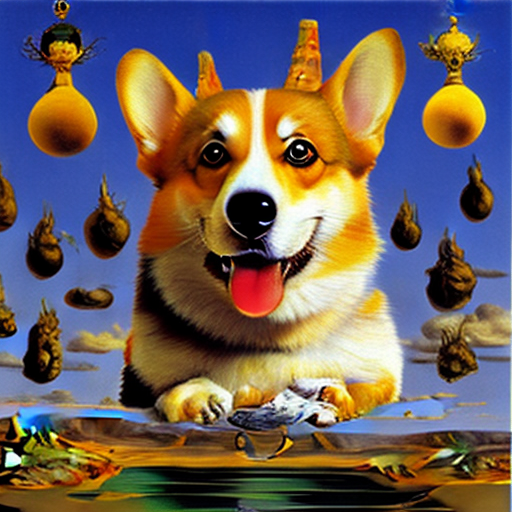

In [16]:
import ipywidgets as widgets

print(f'Input text: {text_prompt.value}')
display(final_image)

Nice, as we can see the picture has quite a high definition 🔥.
Moving slider, we can also view the history of steps to see how noise and blurry outlines turn into an image.

In [17]:
@widgets.interact(step=(1, len(all_frames)))
def display_step(step=0):
    display(all_frames[step - 1])

interactive(children=(IntSlider(value=1, description='step', max=10, min=1), Output()), _dom_classes=('widget-…